In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import copy
import time
from PIL import Image
import seaborn as sns
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load data

In [2]:
from torchvision import transforms, datasets
import torch

# Define augmentation transforms for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(25),              
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),                         
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('/kaggle/input/ioai-journey-to-springfield/journey-springfield/train/simpsons_dataset', transform=train_transforms)
test_data = datasets.ImageFolder('/kaggle/input/ioai-journey-to-springfield/journey-springfield/testset', transform=val_test_transforms)

# train_size = int(len(train_data) * 0.9)
# val_size = len(train_data) - train_size
# train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


In [3]:
class_count = Counter(train_data.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_data)
for i, (data, label) in enumerate(tqdm(train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

  0%|          | 0/20933 [00:00<?, ?it/s]

In [4]:
train_loader = DataLoader(train_data, batch_size=128, sampler=train_sampler, num_workers=4)

# EDA

In [5]:
all_labels = []

for images, labels in train_loader:
    all_labels.append(labels)

for images, labels in val_loader:
     all_labels.append(labels)

all_labels = torch.cat(all_labels).numpy()

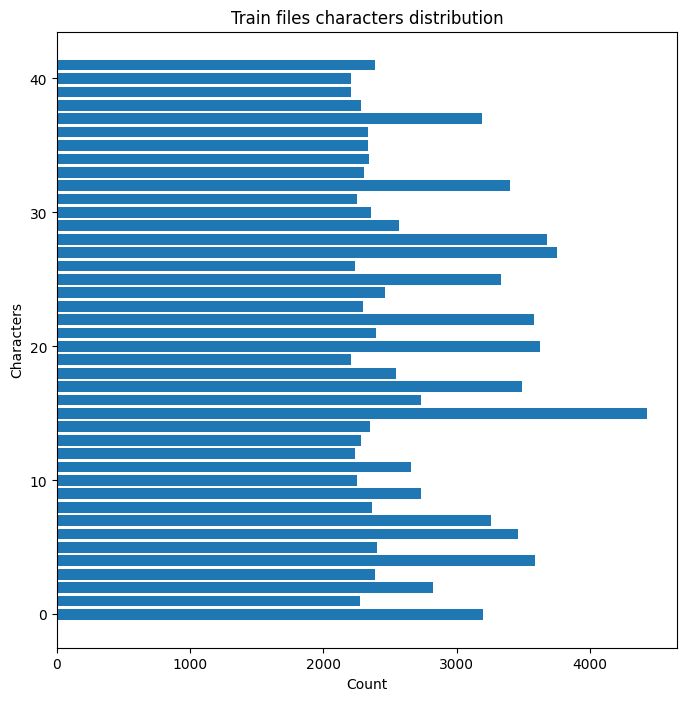

In [6]:
counts = pd.Series(all_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [7]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        img = images[i].numpy()
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

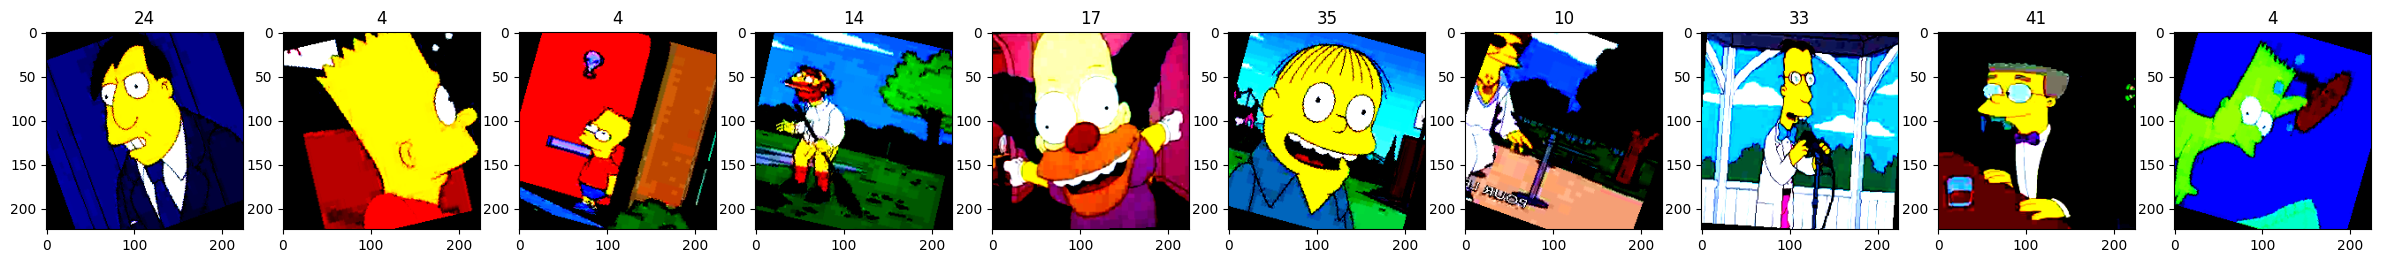

In [8]:
images, labels = next(iter(train_loader))

show_images(images, labels)

# Model

In [9]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


In [10]:
model.fc = nn.Linear(512, 42)

In [11]:
# for param in model.features.parameters():
#     param.requires_grad = False

# for i, param in enumerate(model.classifier.parameters()):
#     if i == 0:
#         param.requires_grad = False

## Train

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = nn.DataParallel(model)

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
from IPython.display import clear_output
from sklearn.metrics import f1_score

def evaluate(model, dataloader, loss_fn=None, name='test'):

    y_pred_list = []
    y_true_list = []

    losses = []

    for i, batch in enumerate(dataloader):
        # так получаем текущий батч
        X_batch, y_batch = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))

            if loss_fn is not None:
                loss = loss_fn(logits, y_batch.to(device))
                losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    f1 = f1_score(y_true_list, y_pred_list, average='macro')

    return f1, np.mean(losses)


def train(model, loss_fn, optimizer, n_epoch=3):

    train_losses = []
    train_f1_scores = []

    val_losses = []
    val_f1_scores = []

    # цикл обучения сети
    for epoch in range(n_epoch):

        model.train(True)

        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            loss.backward()  # backpropagation (вычисление градиентов)
            optimizer.step()  # обновление весов сети
            optimizer.zero_grad()  # обнуляем веса

            # выведем лосс на график раз в 50 итераций обучения
            if i % 50 == 0:

                fig, axes = plt.subplots(2, 2, figsize=(14, 10))

                train_losses.append(loss.item())

                # вычислим f1 на текущем train батче
                model_answers = torch.argmax(logits, dim=1)
                train_f1 = f1_score(y_batch.numpy(), model_answers.cpu().numpy(), average='macro')
                train_f1_scores.append(train_f1)

                train_iterations = np.array(range(len(train_losses))) * 50

                # отрисовываем train_losses
                axes[0, 0].plot(train_iterations, train_losses)
                axes[0, 0].set_title('Train losses')
                axes[0, 0].set(xlabel='Iterations', ylabel='Loss')

                # отрисовываем train_f1_scores
                axes[0, 1].plot(train_iterations, train_f1_scores)
                axes[0, 1].set_title('Train F1 Scores')
                axes[0, 1].set(xlabel='Iterations', ylabel='F1 Score')

                val_iterations = np.array(range(len(val_losses))) * 50

                axes[1, 0].plot(val_iterations, val_losses)
                axes[1, 0].set_title('Val losses')
                axes[1, 0].set(xlabel='Iterations', ylabel='Loss')

                axes[1, 1].plot(val_iterations, val_f1_scores)
                axes[1, 1].set_title('Val F1 Scores')
                axes[1, 1].set(xlabel='Iterations', ylabel='F1 Score')

                plt.show()

                clear_output(wait=True)

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_f1, val_loss = evaluate(model, val_loader, loss_fn=loss_fn, name='val')
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

    return model, train_losses, val_losses, val_f1_scores


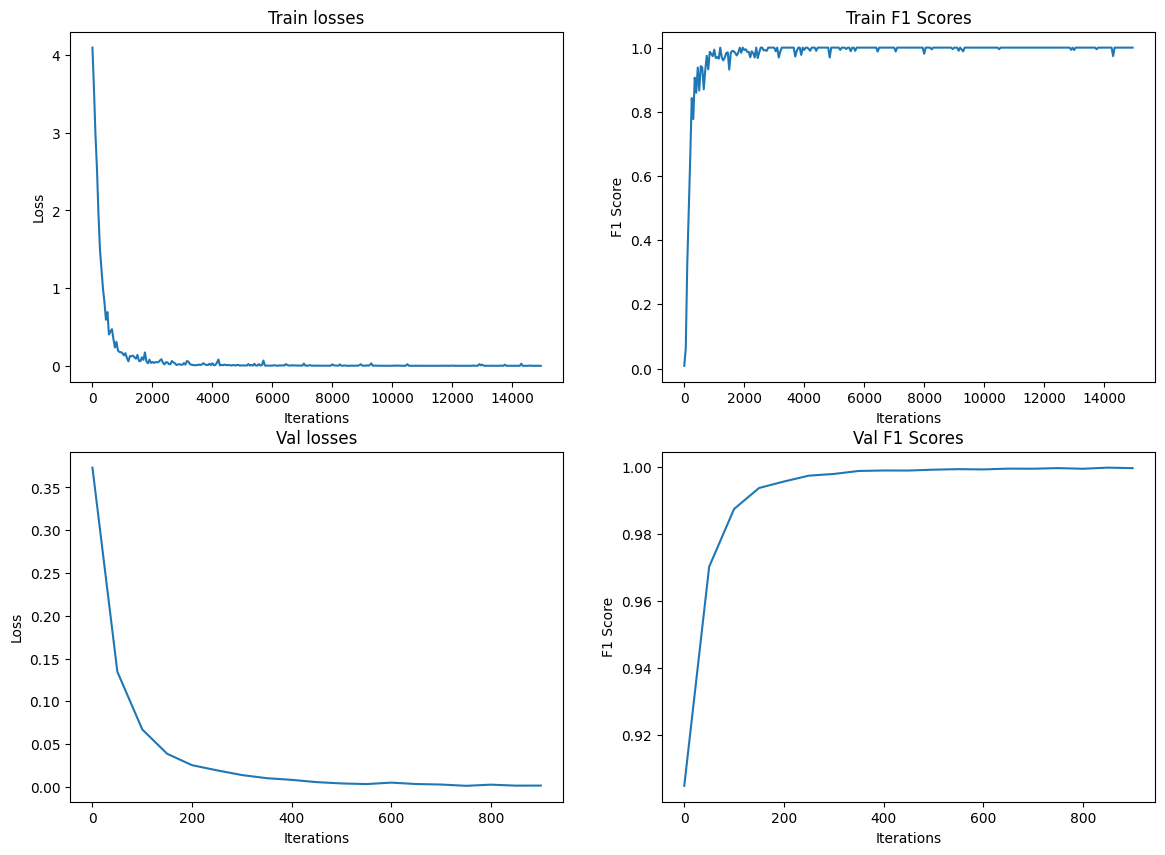

In [15]:
model, train_losses, val_losses, val_accuracies = train(model, loss_fn, optimizer, n_epoch=20)

In [16]:
val_f1, _ = evaluate(model, val_loader);
print('Val f1 is', val_f1)

Val f1 is 0.9996415465776326


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Test predict

In [17]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class_to_idx = train_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

base_transform = transforms.Compose([
    transforms.Resize(256),                         
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


tta_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(degrees=20)
])

def predict_with_tta(model, dataset, n_tta=5, device="cuda"):
    model.eval()
    filenames = []
    final_predictions = []

    with torch.no_grad():
        for img_path, _ in dataset.imgs:
            image = Image.open(img_path).convert("RGB")
            image_base = base_transform(image)
            
            logits_list = []
            for _ in range(n_tta):
                aug_image = tta_transform(image)
                aug_image = base_transform(aug_image)
                input_tensor = aug_image.unsqueeze(0).to(device)
                logits = model(input_tensor)
                logits_list.append(logits.cpu().numpy())
            
            avg_logits = np.mean(np.vstack(logits_list), axis=0)
            pred_class = np.argmax(avg_logits)
            final_predictions.append(pred_class)
            filenames.append(os.path.basename(img_path))
    
    return filenames, final_predictions

filenames, predictions = predict_with_tta(model, test_loader.dataset, n_tta=5, device=device)

predicted_classes = [idx_to_class[pred] for pred in predictions]

submission_df = pd.DataFrame({
    'Id': filenames,
    'Expected': predicted_classes
})

submission_df.to_csv('submission.csv', index=False)
